In [20]:
import pandas as pd
import numpy as np
!pip install yfinance
import yfinance as yf
!pip install pandas_ta
import pandas_ta as ta
import matplotlib.pyplot as plt

In [21]:
hdb=yf.Ticker("HCLTECH.NS")
hdb.history(period="1y")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-03-01 00:00:00+05:30,1024.419051,1049.759742,1024.419051,1047.002197,1655100,0.0,0.0
2023-03-02 00:00:00+05:30,1036.733000,1062.121167,1036.733000,1051.614014,4074162,0.0,0.0
2023-03-03 00:00:00+05:30,1060.219471,1074.197206,1056.463583,1064.022949,3253621,0.0,0.0
2023-03-06 00:00:00+05:30,1073.531651,1091.598171,1068.111741,1071.344604,4091674,0.0,0.0
2023-03-08 00:00:00+05:30,1057.366875,1068.777309,1052.897834,1065.591919,3209393,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-26 00:00:00+05:30,1665.750000,1668.849976,1639.500000,1649.800049,1844253,0.0,0.0
2024-02-27 00:00:00+05:30,1649.000000,1673.400024,1648.000000,1658.800049,2049420,0.0,0.0
2024-02-28 00:00:00+05:30,1664.699951,1672.000000,1644.199951,1651.900024,936575,0.0,0.0


In [24]:
def ema(data,window):
  return data['Close'].ewm(span=window).mean()
def rsi(data):
 delta=data['Close'].diff()
 gain=delta.where(delta>0,0)
 loss=-delta.where(delta<0,0)
 avg_gain=gain.rolling(window=14).mean()
 avg_loss=loss.rolling(window=14).mean()
 rs=avg_gain/avg_loss
 rsi=100-(100/(1+rs))
 return rsi
def signals(data,ema_window1,ema_window2):
  signals=pd.DataFrame(index=data.index)
  signals['EMA_short']=ema(data,ema_window1)
  signals['EMA_long']=ema(data,ema_window2)
  signals['RSI']=rsi(data)
  signals['Signal'] = 0
  signals['Signal']=np.where((signals['EMA_short']>signals['EMA_long']) & (signals['EMA_short'].shift(1) <= signals['EMA_long'].shift(1)) & signals['RSI']>70,1.0,0.0)
  signals['Signal'] = signals['Signal'].replace(0, np.nan).fillna(method='ffill')
  signals['Signal']=np.where((signals['EMA_short']<signals['EMA_long']) & (signals['EMA_long'].shift(1) <= signals['EMA_short'].shift(1)) & signals['RSI']<30,-1.0,signals['Signal'])
  signals['Signal'] = signals['Signal'].replace(0, np.nan).fillna(method='ffill')

  return(signals)



In [25]:
data=hdb.history(period="4y")
ema_window1=5
ema_window2=12
signals=signals(data,ema_window1,ema_window2).dropna()
print(signals)







                             EMA_short     EMA_long        RSI  Signal
Date                                                                  
2020-03-20 00:00:00+05:30   386.335668   408.888595  26.711140    -1.0
2020-03-23 00:00:00+05:30   377.822858   400.842239  23.778462    -1.0
2020-03-24 00:00:00+05:30   379.349327   397.793736  26.553595    -1.0
2020-03-25 00:00:00+05:30   384.854083   397.475625  30.880791    -1.0
2020-03-26 00:00:00+05:30   385.664216   395.825942  26.385301    -1.0
...                                ...          ...        ...     ...
2024-02-26 00:00:00+05:30  1660.315179  1651.318796  55.895011    -1.0
2024-02-27 00:00:00+05:30  1659.810136  1652.469758  59.805933    -1.0
2024-02-28 00:00:00+05:30  1657.173432  1652.382106  54.309521    -1.0
2024-02-29 00:00:00+05:30  1659.398947  1654.146394  57.600008    -1.0
2024-03-01 00:00:00+05:30  1657.832615  1654.231557  46.802398    -1.0

[980 rows x 4 columns]


In [26]:
def backtest(data,signals,initial_capital=100001,compound=True):
    positions = pd.DataFrame(index=data.index)
    positions['Position'] = signals['Signal']
    positions['Stock'] = 100 * positions['Position'] #Buying 50 shares
    portfolio = positions.multiply(data['Close'], axis=0)
    pos_diff = positions.diff()
    portfolio['Cash'] = initial_capital - (pos_diff['Stock'] * data['Close']).cumsum()
    portfolio['Total'] = portfolio['Stock'] + portfolio['Cash']
    portfolio['Returns'] = portfolio['Total'].pct_change()
    if compound:
        portfolio['Returns'] = (1 + portfolio['Returns']).cumprod() - 1
    return portfolio
portfolio=backtest(data,signals).dropna()
print(portfolio)

                              Position          Stock      Cash         Total  \
Date                                                                            
2020-03-24 00:00:00+05:30  -382.395294  -38239.529419  100001.0  61761.470581   
2020-03-25 00:00:00+05:30  -395.846832  -39584.683228  100001.0  60416.316772   
2020-03-26 00:00:00+05:30  -387.282837  -38728.283691  100001.0  61272.716309   
2020-03-27 00:00:00+05:30  -372.533752  -37253.375244  100001.0  62747.624756   
2020-03-30 00:00:00+05:30  -362.455872  -36245.587158  100001.0  63755.412842   
...                                ...            ...       ...           ...   
2024-02-26 00:00:00+05:30 -1649.800049 -164980.004883  100001.0 -64979.004883   
2024-02-27 00:00:00+05:30 -1658.800049 -165880.004883  100001.0 -65879.004883   
2024-02-28 00:00:00+05:30 -1651.900024 -165190.002441  100001.0 -65189.002441   
2024-02-29 00:00:00+05:30 -1663.849976 -166384.997559  100001.0 -66383.997559   
2024-03-01 00:00:00+05:30 -1

<Axes: title={'center': 'Equity Curve'}, xlabel='Date'>

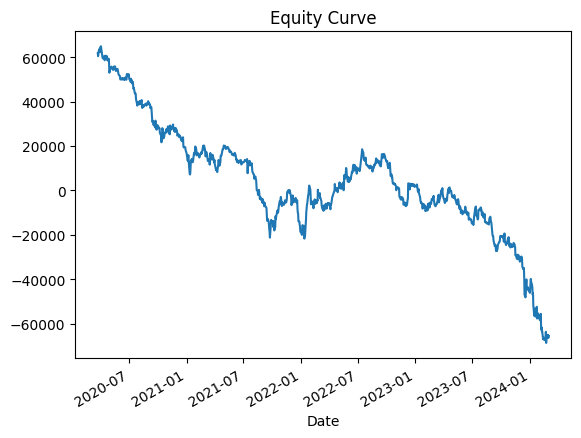

In [27]:
portfolio['Total'].plot(title="Equity Curve")

<Axes: title={'center': 'Drawdown chart'}, xlabel='Date'>

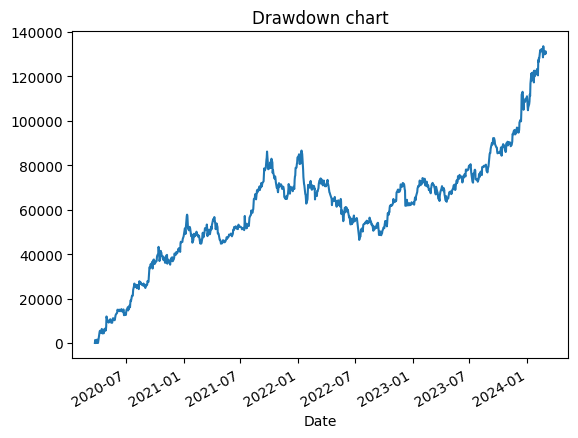

In [28]:
(portfolio['Total'].cummax()-portfolio['Total']).plot(title="Drawdown chart")

<Axes: title={'center': 'Volatility Chart'}, xlabel='Date'>

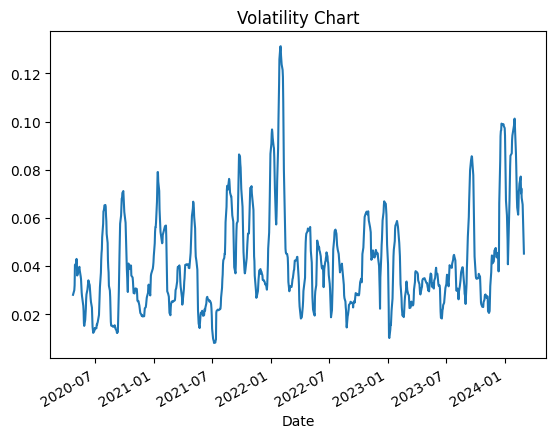

In [29]:
(portfolio['Returns'].rolling(window=20).std()).plot(title="Volatility Chart")

In [30]:
avg_return=portfolio['Returns'].mean()
stdev_return=portfolio['Returns'].std()
R=0.06
sharpe=(avg_return-R)/stdev_return
print(sharpe)

-2.5367525255143546
